Sketch out tweaks/new routines for visualizing results from the sampling experiments.

In [1]:
import os, pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', context='talk')

import utils

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Autoload extension

In [2]:
%load_ext autoreload
%autoreload 2

This time, we load in the results of the sampling study using actual MARC aerosol fields.

The dataset contains the parameters and model/parameterization evaluations for each of the 10,000 samplesets. Where indicated, parameters prefixed with `log` are the $\log_{10}$ value of those quantities. *All* of the function evaluates are stored as the $\log_{10}$ of their true values. The following variables are available in the dataset:

- **Smax**: Calculated supersaturation maxima for parcel and *all* parameterizations
- **Neq/Nkn**: Calculated equilibrium/kinetically limited droplet number concentration, for parcel model. For parameterizations, these are the chaos expansions predicting these quantities.
- **Nderiv**: Calculated diagnosed droplet number concentration, for parameterizations only.


In [3]:
design = pd.read_csv("data/aerosol_sampling/MARC_aerosol_design.csv")
results_gCCN = pd.read_csv("data/aerosol_sampling/MARC_gCCN_aerosol_design_parameterization_results.csv")
results_main = pd.read_csv("data/aerosol_sampling/MARC_main_aerosol_design_parameterization_results.csv")
results_parcel = pd.read_csv("data/aerosol_sampling/MARC_gCCN_aerosol_design_parcel_results.csv")

Theres a small glitch in the results files for the gCCN and main PCM schemes; **Nderiv_expansion_order_4** actually holds a string representing a tuple of values for **Smax_ARG**, **Nderiv_ARG**, **Smax_MBN**, **Nderiv_MBN**, and then finally the value we want, as illustrated below:

In [4]:
n = np.random.randint(10000)
print(results_gCCN['Nderiv_expansion_order_4'].ix[n])
print(results_gCCN.ix[n])

(-2.5107594359691978, 2.1804051900175292, -2.5210411887366027, 2.1764222551099954, 2.180899548927353)
Unnamed: 0                                                               4561
Smax_expansion_order_3                                               -2.40914
Nderiv_expansion_order_3                                               2.2109
Neq_expansion_order_3                                                 2.48783
Nkn_expansion_order_3                                                 1.30748
Smax_expansion_order_4                                               -2.50938
Nderiv_expansion_order_4    (-2.5107594359691978, 2.1804051900175292, -2.5...
Neq_expansion_order_4                                                 2.40174
Nkn_expansion_order_4                                                 1.82919
Smax_ARG                                                             -2.51076
Nderiv_ARG                                                            2.18041
Smax_MBN                                


We want to extract just this value, which we'll do by applying a function over that column.

In [5]:
s = results_gCCN['Nderiv_expansion_order_4'].ix[n]

def extract_nth_from_str(s, n=0):
    """ Extract nth bit from a str representing a tuple of floats. Here,
    n represents the actual ordinal count in the tuple. """
    bits = s.strip()[1:-1].split(", ")
    try:
        retval = float(bits[n-1])
    except IndexError:
        return np.nan
    return float(bits[n-1])
extract_nth_from_str(s)

# test = results_main.Nderiv_expansion_order_4.apply(extract_nth_from_str, args=(5, ))
results_main = results_main.assign(
    Nderiv_expansion_order_4=\
        results_main.Nderiv_expansion_order_4.apply(extract_nth_from_str, args=(5, ))
)
results_gCCN = results_gCCN.assign(
    Nderiv_expansion_order_4=\
        results_gCCN.Nderiv_expansion_order_4.apply(extract_nth_from_str, args=(5, ))
)

With this accomplished, we can begin to compare the parcel model and activation schemes. First, it'll be useful to have histograms of the activation parameters for quick reference

In [6]:
design_subset = design[[p for p in design.columns 
                        if p not in ['lev', 'ORO', 'Unnamed: 0', 'Q']]]

# Dictionary for looking up param bounds
params_dict = pd.read_pickle("data/MARC_gCCN/MARC_gCCN_exp.dict")
variables = params_dict['variables']
bounds = {v[0]: v[3][1:] for v in variables}

ncol, nrow = 4, 4
size = 3. 
aspect=16./10.

# Compute figure sizing
fig_width = ncol * size * aspect
fig_height = nrow * size

default_subplot_kw = dict(aspect='auto')
fig, axes = plt.subplots(nrow, ncol, figsize=(fig_width, fig_height), squeeze=False,
                         subplot_kw=default_subplot_kw)

# Slightly tweak spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for i, (ax, col) in enumerate(zip(axes.ravel(), design_subset.columns)):
    data = design_subset[col]
        
    if col.startswith('log'):
        lo, hi = bounds[col]
        data[data < -10] = np.nan
        data[data < lo] = np.nan
        data[data > hi] = np.nan
    data.dropna(inplace=True)
    
    sns.distplot(design_subset[col], ax=ax, label=col, color='k')
    try:
        ax.set_xlim(*bounds[col])
    except KeyError:
        pass
    
plt.tight_layout()

fig_fn = "figs/aerosol_sampling_dist"
# plt.savefig(fig_fn+".png", transparent=True, dpi=200, bbox_inches='tight')
# plt.savefig(fig_fn+".pdf", transparent=True, bbox_inches='tight')

**Plot 1:** one-one comparison b/t parameterizations and parcel model

main_3
9987
6768 3219
Smax_oneone.MARC_aerosol.main_3
gCCN_3
9890
6768 3122
Smax_oneone.MARC_aerosol.gCCN_3
main_4
9989
6768 3221
Smax_oneone.MARC_aerosol.main_4
gCCN_4
9946
6768 3178
Smax_oneone.MARC_aerosol.gCCN_4
ARG
10000
6768 3232
Smax_oneone.MARC_aerosol.ARG
MBN
10000
6768 3232
Smax_oneone.MARC_aerosol.MBN


/Users/daniel/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


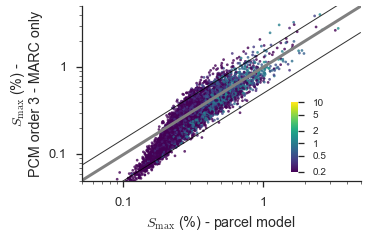

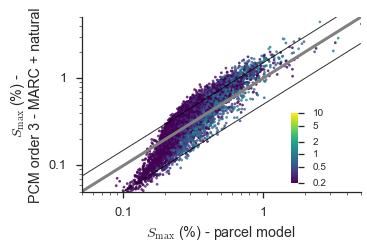

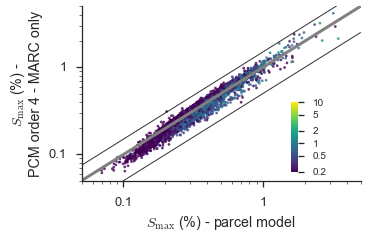

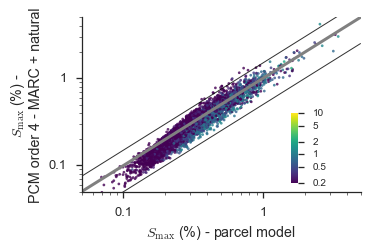

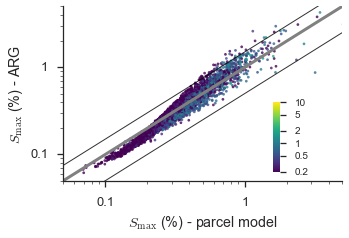

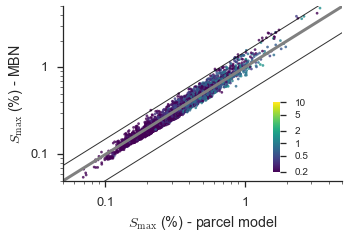

In [17]:
# Smax

var_name = "Smax"
var_label = '$S_\mathrm{max}$ (%)'
lims = 0.05, 5.
parcel_data = np.power(10., results_parcel[var_name+"_parcel"])
coloring = np.power(10., design['logV'])
coloring_ticks = [0.02, 0.05, 0.1, 0.2, 0.5, 1., 2.0, 5., 10.]

# Different from the oneone_plots.ipynb notebook, here we hard-code in the
# data source
param_settings = [
    # ( name, label )
    ('main_3', '\nPCM order 3 - MARC only',      results_main[var_name+"_expansion_order_3"]),
    ('gCCN_3', '\nPCM order 3 - MARC + natural', results_gCCN[var_name+"_expansion_order_3"]),
    ('main_4', '\nPCM order 4 - MARC only',      results_main[var_name+"_expansion_order_4"]),
    ('gCCN_4', '\nPCM order 4 - MARC + natural', results_gCCN[var_name+"_expansion_order_4"]),
    ('ARG', 'ARG', results_gCCN[var_name+"_ARG"]),
    ('MBN', 'MBN', results_gCCN[var_name+"_MBN"]),
]
for param_name, param_label, scheme_data in param_settings:
    print(param_name)
    scheme_data = np.power(10., scheme_data)
    
    # Mask egregious outlier data
    data_df = pd.DataFrame({'scheme': scheme_data,
                            'parcel': parcel_data,
                            'coloring': coloring})
    
    # Convert to supersaturation in %
    data_df['scheme'] *= 100
    data_df['parcel'] *= 100
    
    # Note that the data is all log data, so we're masking truly outlier
    # points here
    bad_mask = (data_df > 1e10) | (data_df < 0.) 
    data_df[bad_mask] = np.nan
    data_df.dropna(inplace=True)
    print(len(data_df))

    var_bounds = True
    # Create subset of data based on variable boundaries
    for term in bounds.keys():
        lo, hi = bounds[term]
        var_bounds = var_bounds & \
                    (design_subset[term] > lo) & \
                    (design_subset[term] < hi)
    print(len(data_df[var_bounds]), len(data_df[~var_bounds]))
    
    # in bounds
    fig, ax = utils.plot_oneone(data_df['parcel'][var_bounds], 
                             data_df['scheme'][var_bounds],
                             var_label, param_label,
                             color_data=data_df['coloring'][var_bounds], 
                             color_ticks=coloring_ticks,
                             color_bar=True, lims=lims,
                             scatter_kws=dict(marker='.'))
    # out of bounds
#     fig, ax = utils.plot_oneone(data_df['parcel'][~var_bounds], 
#                              data_df['scheme'][~var_bounds],
#                              var_label, param_label,
#                              color_data=data_df['coloring'][~var_bounds], 
#                              color_ticks=coloring_ticks,
#                              color_bar=True, lims=lims,
#                              scatter_kws=dict(marker='x', s=40), ax=ax)

    fig_fn = "{}_oneone.MARC_aerosol.{}".format(var_name, param_name)
    print(fig_fn)
#     plt.savefig("figs/"+fig_fn+".png", transparent=True, bbox_inches='tight',
#                 dpi=200)
#     plt.savefig("figs/"+fig_fn+".pdf", transparent=True, bbox_inches='tight')

main_3
9839
6768 3071
Nact_oneone.MARC_aerosol.main_3
gCCN_3
9839
6768 3071
Nact_oneone.MARC_aerosol.gCCN_3
main_4
9839
6768 3071
Nact_oneone.MARC_aerosol.main_4
gCCN_4
9839
6768 3071
Nact_oneone.MARC_aerosol.gCCN_4
ARG
9839
6768 3071
Nact_oneone.MARC_aerosol.ARG
MBN
9839
6768 3071
Nact_oneone.MARC_aerosol.MBN


/Users/daniel/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


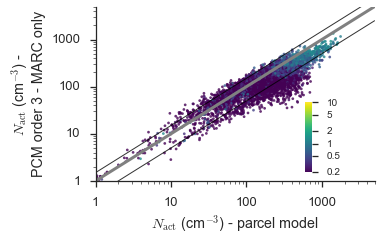

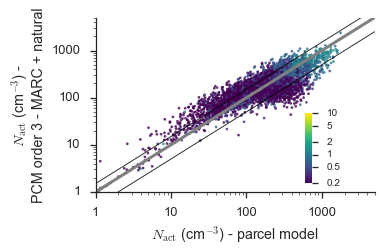

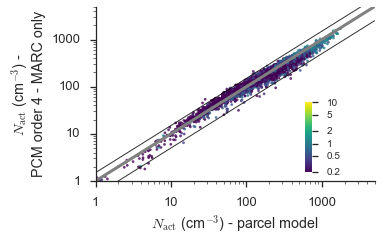

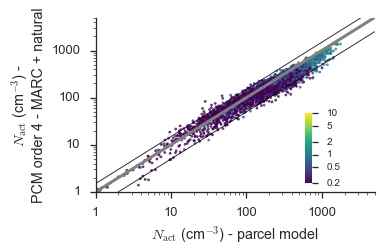

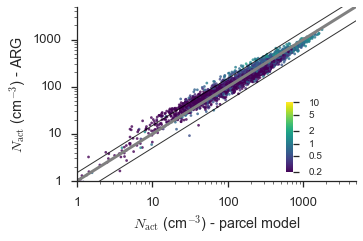

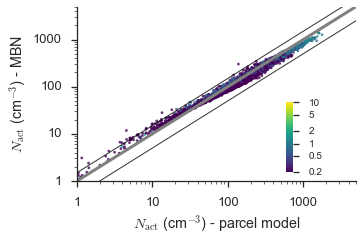

In [18]:
# Neq vs Nderiv

var_name = "Nact"
var_label = '$N_\mathrm{act}$ (cm$^{-3}$)'
lims = 1.0, 5e3
parcel_data = np.power(10., results_parcel["Neq_parcel"])
coloring = np.power(10., design['logV'])
coloring_ticks = [0.02, 0.05, 0.1, 0.2, 0.5, 1., 2.0, 5., 10.]

# Different from the oneone_plots.ipynb notebook, here we hard-code in the
# data source
param_settings = [
    # ( name, label )
    ('main_3', '\nPCM order 3 - MARC only', results_main["Nderiv_expansion_order_3"]),
    ('gCCN_3', '\nPCM order 3 - MARC + natural', results_gCCN["Nderiv_expansion_order_3"]),
    ('main_4', '\nPCM order 4 - MARC only', results_main["Nderiv_expansion_order_4"]),
    ('gCCN_4', '\nPCM order 4 - MARC + natural', results_gCCN["Nderiv_expansion_order_4"]),
    ('ARG', 'ARG', results_gCCN["Nderiv_ARG"]),
    ('MBN', 'MBN', results_gCCN["Nderiv_MBN"]),
]
for param_name, param_label, scheme_data in param_settings:
    print(param_name)
    scheme_data = np.power(10., scheme_data)
    
    # Mask egregious outlier data
    data_df = pd.DataFrame({'scheme': scheme_data,
                            'parcel': parcel_data,
                            'coloring': coloring})
    
    # Note that the data is all log data, so we're masking truly outlier
    # points here
    bad_mask = (data_df > 1e10) | (data_df < 0.) | (data_df == 1.)
    data_df[bad_mask] = np.nan
    data_df.dropna(inplace=True)
    print(len(data_df))

    var_bounds = True
    # Create subset of data based on variable boundaries
    for term in bounds.keys():
        lo, hi = bounds[term]
        var_bounds = var_bounds & \
                    (design_subset[term] > lo) & \
                    (design_subset[term] < hi)
    print(len(data_df[var_bounds]), len(data_df[~var_bounds]))
    
    # in bounds
    fig, ax = utils.plot_oneone(data_df['parcel'][var_bounds], 
                             data_df['scheme'][var_bounds],
                             var_label, param_label,
                             color_data=data_df['coloring'][var_bounds], 
                             color_ticks=coloring_ticks,
                             color_bar=True, lims=lims,
                             scatter_kws=dict(marker='.'))
    # out of bounds
#     fig, ax = utils.plot_oneone(data_df['parcel'][~var_bounds], 
#                              data_df['scheme'][~var_bounds],
#                              var_label, param_label,
#                              color_data=data_df['coloring'][~var_bounds], 
#                              color_ticks=coloring_ticks,
#                              color_bar=True, lims=lims,
#                              scatter_kws=dict(marker='x', s=40), ax=ax)

    fig_fn = "{}_oneone.MARC_aerosol.{}".format(var_name, param_name)
    print(fig_fn)
#     plt.savefig("figs/"+fig_fn+".png", transparent=True, bbox_inches='tight',
#                 dpi=200)
#     plt.savefig("figs/"+fig_fn+".pdf", transparent=True, bbox_inches='tight')

---
